In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from scipy import stats
from google.colab import files # Импорт модуля для загрузки файлов
import io

# Устанавливаем стиль для единообразия графиков.
sns.set_style("whitegrid")

# --- Цель блока: Импортировать все необходимые библиотеки и загрузить/подготовить исходные данные. ---
# --- Логика: Вызываем диалог загрузки файла с компьютера пользователя. После загрузки ---
# --- данные считываются в DataFrame и искусственно добавляются пропуски для демонстрации импутации. ---

print("Пожалуйста, загрузите файл 'heart.csv' со своего компьютера.")
uploaded = files.upload() # Запускает диалоговое окно для выбора файла

# Считываем загруженный файл в DataFrame
file_name = next(iter(uploaded)) # Получаем имя первого загруженного файла
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

print(f"✅ Файл '{file_name}' успешно загружен.")

# Приведение названий столбцов к понятному формату
df.columns = ['Age', 'Sex', 'ChestPainType', 'RestBP', 'Cholesterol', 'FastingBS', 'RestECG', 'MaxHR', 'ExAng', 'OldPeak', 'Slope', 'MajorVessels', 'Thal', 'Target']

# Искусственное добавление пропусков (3%) для демонстрации импутации
for col in ['RestBP', 'Cholesterol', 'MaxHR', 'MajorVessels']:
    df.loc[df.sample(frac=0.03).index, col] = np.nan

df_cleaned = df.copy()
print(f"Размер исходного датасета: {df_cleaned.shape}")

Пожалуйста, загрузите файл 'heart.csv' со своего компьютера.


Saving Heart_Disease_Prediction.csv to Heart_Disease_Prediction.csv
✅ Файл 'Heart_Disease_Prediction.csv' успешно загружен.
Размер исходного датасета: (270, 14)


In [3]:
print("\n--- Шаг 1: Оценка Качества Данных ---")

# --- Цель блока: Оценить наличие пропусков и дубликатов, а также идентифицировать типы переменных. ---
# --- Логика: Подсчет процента пропусков и удаление полных дубликатов для обеспечения чистоты данных. ---

# 1.1 Оценка пропусков
missing_info = df_cleaned.isnull().sum()
missing_percent = (missing_info / len(df_cleaned)) * 100
missing_df = pd.DataFrame({'Пропуски (%)': missing_percent.round(2)})
missing_df = missing_df[missing_df['Пропуски (%)'] > 0].sort_values(by='Пропуски (%)', ascending=False)
print("1.1 Пропуски:")
display(missing_df)

# 1.2 Оценка дубликатов
duplicate_count = df_cleaned.duplicated().sum()
df_cleaned.drop_duplicates(inplace=True)
print(f"\n1.2 Дубликаты: Удалено {duplicate_count} строк.")

# 1.3 Определение типов переменных
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestECG', 'ExAng', 'Slope', 'MajorVessels', 'Thal']
numerical_cols = ['Age', 'RestBP', 'Cholesterol', 'MaxHR', 'OldPeak']
print("\n1.3 Типы переменных: Успешно определены для дальнейшей обработки.")


--- Шаг 1: Оценка Качества Данных ---
1.1 Пропуски:


,Пропуски (%)
RestBP,2.96
Cholesterol,2.96
MaxHR,2.96
MajorVessels,2.96



1.2 Дубликаты: Удалено 0 строк.

1.3 Типы переменных: Успешно определены для дальнейшей обработки.


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Пропуски (%)']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Пропуски (%)'}, axis=1)
              .sort_values('Пропуски (%)', ascending=True))
  xs = counted['Пропуски (%)']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = missing_df.sort_values('Пропуски (%)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Пропуски (%)')
_ = plt.ylabel('count()')

In [5]:
print("\n--- Шаг 3: Заполнение Пропусков (3 Способа) ---")

# --- Цель блока: Продемонстрировать и выбрать один из трех методов импутации пропусков. ---
# --- Логика: Применяем Медиану, Моду и Константу к числовым столбцам с пропусками. ---
# --- Медиана (Method 1) выбирается для дальнейшей работы как наиболее устойчивый метод. ---

cols_with_missing = missing_df.index.tolist()
numerical_cols_to_impute = [col for col in cols_with_missing if col in numerical_cols or col == 'MajorVessels']

if numerical_cols_to_impute:
    # 1. Заполнение Медианой (выбирается для дальнейшей работы)
    df_method1 = df_cleaned.copy()
    imputer_median = SimpleImputer(strategy='median')
    df_method1[numerical_cols_to_impute] = imputer_median.fit_transform(df_method1[numerical_cols_to_impute])
    print(f"1. Заполнение Медианой (выбрано для работы): {numerical_cols_to_impute}")

    # 2. Заполнение Модой (для демонстрации)
    df_method2 = df_cleaned.copy()
    imputer_most_frequent = SimpleImputer(strategy='most_frequent')
    df_method2[numerical_cols_to_impute] = imputer_most_frequent.fit_transform(df_method2[numerical_cols_to_impute])

    # 3. Заполнение Константой (для демонстрации)
    df_method3 = df_cleaned.copy()
    imputer_constant = SimpleImputer(strategy='constant', fill_value=-999)
    df_method3[numerical_cols_to_impute] = imputer_constant.fit_transform(df_method3[numerical_cols_to_impute])

    df_final = df_method1 # Используем данные, заполненные медианой
else:
    df_final = df_cleaned.copy()
    print("Пропуски отсутствуют.")


--- Шаг 3: Заполнение Пропусков (3 Способа) ---
1. Заполнение Медианой (выбрано для работы): ['RestBP', 'Cholesterol', 'MaxHR', 'MajorVessels']


In [6]:
print("\n--- Шаг 4: Кодирование Категориальных Переменных (3 Способа) ---")

# --- Цель блока: Продемонстрировать и выбрать один из трех методов кодирования категорий. ---
# --- Логика: Применяем One-Hot Encoding (для номинальных), Label Encoding (для порядковых/двоичных) ---
# --- и Frequency Encoding (для демонстрации). One-Hot Encoding выбирается как основной метод. ---

# 1. One-Hot Encoding (OHE) - выбирается для дальнейшей работы
ohe_cols = ['ChestPainType', 'RestECG', 'Slope', 'Thal']
df_ohe = pd.get_dummies(df_final, columns=ohe_cols, prefix=ohe_cols)
print(f"1. One-Hot Encoding (выбрано для работы): Признаки {ohe_cols} закодированы.")

# 2. Label Encoding (для демонстрации)
le_cols = ['Sex', 'ExAng', 'FastingBS'] # Двоичные признаки
df_le = df_final.copy()
le = LabelEncoder()
for col in le_cols:
    df_le[col] = le.fit_transform(df_le[col].astype(str))

# 3. Frequency/Count Encoding (для демонстрации)
freq_cols = ['MajorVessels']
df_freq = df_final.copy()
for col in freq_cols:
    freq_map = df_final[col].value_counts(normalize=True).to_dict()
    df_freq[col + '_Freq'] = df_freq[col].map(freq_map)
    df_freq.drop(columns=[col], inplace=True)

# Используем данные, закодированные OHE
df_final = df_ohe


--- Шаг 4: Кодирование Категориальных Переменных (3 Способа) ---
1. One-Hot Encoding (выбрано для работы): Признаки ['ChestPainType', 'RestECG', 'Slope', 'Thal'] закодированы.



--- Шаг 5: Оценка и Удаление Выбросов ---


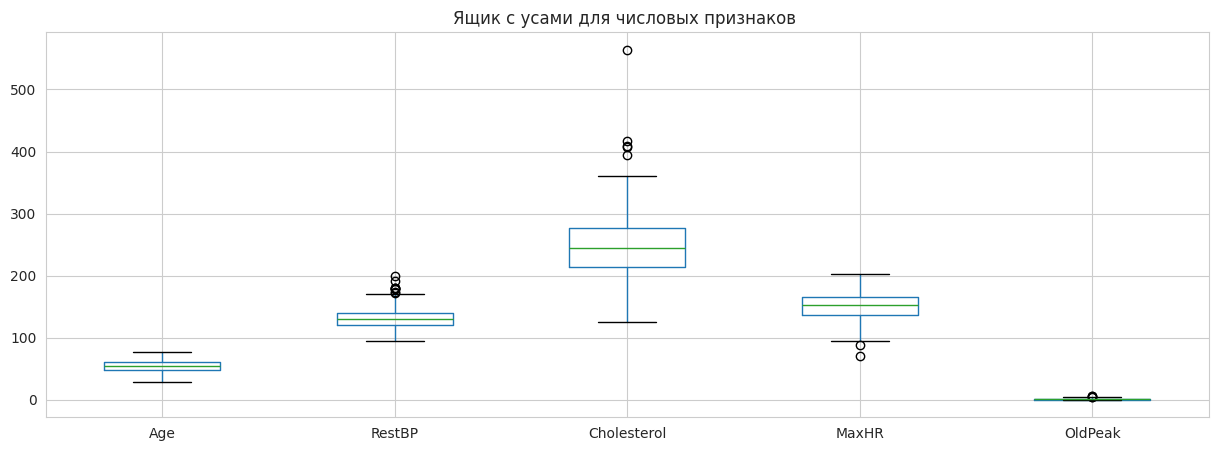

Удалено строк из-за выбросов: 9 (3.33%)

✅ Набор данных после предобработки сохранен.


In [7]:
print("\n--- Шаг 5: Оценка и Удаление Выбросов ---")

# --- Цель блока: Оценить и удалить выбросы для повышения надежности модели. ---
# --- Логика: Визуализация с помощью Ящика с усами. Удаление экстремальных значений ---
# --- с помощью Z-оценки (> 3) для обеспечения статистической корректности данных. ---

# 1. Визуальная оценка выбросов
plt.figure(figsize=(15, 5))
df_final[numerical_cols].boxplot()
plt.title('Ящик с усами для числовых признаков ')
plt.show()

# 2. Удаление выбросов с помощью Z-оценки
df_no_outliers = df_final.copy()
initial_rows = len(df_no_outliers)

for col in numerical_cols:
    df_no_outliers[f'{col}_ZScore'] = np.abs(stats.zscore(df_no_outliers[col]))
    df_no_outliers = df_no_outliers[df_no_outliers[f'{col}_ZScore'] < 3]
    df_no_outliers.drop(columns=[f'{col}_ZScore'], inplace=True)

rows_removed = initial_rows - len(df_no_outliers)
print(f"Удалено строк из-за выбросов: {rows_removed} ({rows_removed / initial_rows * 100:.2f}%)")

df_final_preprocessed = df_no_outliers
# Сохраняем набор данных после предобработки
df_final_preprocessed.to_csv('heart_preprocessed.csv', index=False)
print("\n✅ Набор данных после предобработки сохранен.")


--- Шаг 6: Метод Главных Компонент (PCA) ---
Объясненная дисперсия 2-мя компонентами: 29.10%


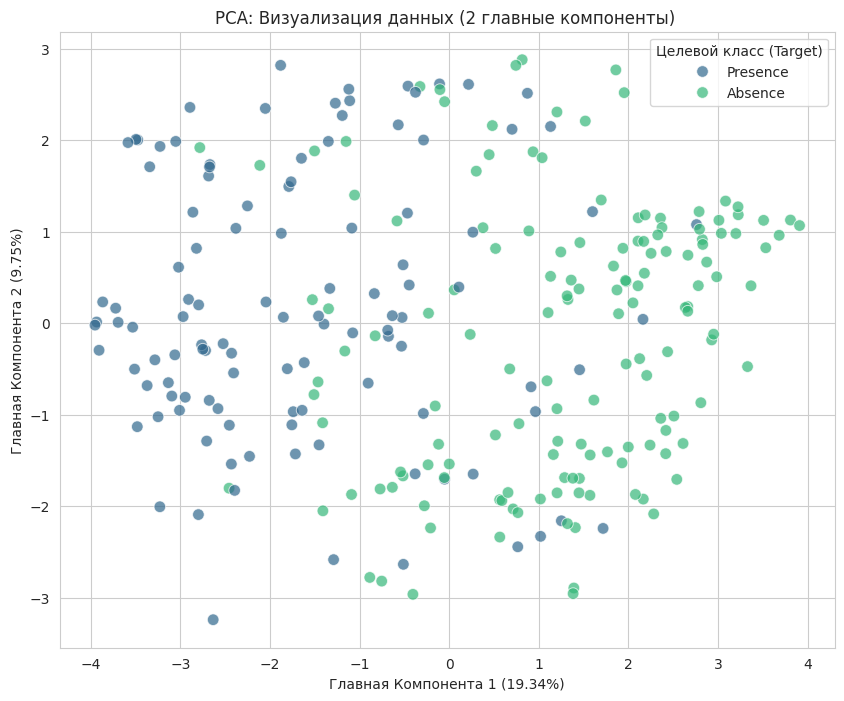

Объясненная дисперсия 3-мя компонентами: 37.13%


In [8]:
print("\n--- Шаг 6: Метод Главных Компонент (PCA) ---")

# --- Цель блока: Сжать признаковое пространство (снижение размерности) и визуализировать ---
# --- разделение классов в сжатом пространстве. ---
# --- Логика: Стандартизация данных (обязательно перед PCA), применение PCA до 2-х компонент, ---
# --- расчет объясненной дисперсии и построение диаграммы рассеивания. ---

# Разделение данных и стандартизация (обязательно перед PCA)
X = df_final_preprocessed.drop('Target', axis=1)
y = df_final_preprocessed['Target']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Сжатие до 2х компонент
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)
print(f"Объясненная дисперсия 2-мя компонентами: {pca_2d.explained_variance_ratio_.sum() * 100:.2f}%")

# 2. Визуализация 2х компонент
pca_df_2d = pd.DataFrame(data=X_pca_2d, columns=['PC1', 'PC2'])
pca_df_2d['Target'] = y.values
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Target', data=pca_df_2d, palette='viridis', s=70, alpha=0.7)
plt.title('PCA: Визуализация данных (2 главные компоненты) ')
plt.xlabel(f'Главная Компонента 1 ({pca_2d.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Главная Компонента 2 ({pca_2d.explained_variance_ratio_[1]*100:.2f}%)')
plt.legend(title='Целевой класс (Target)')
plt.show()

# 3. Сжатие до 3х компонент (для сравнения)
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
print(f"Объясненная дисперсия 3-мя компонентами: {pca_3d.explained_variance_ratio_.sum() * 100:.2f}%")

In [9]:
print("\n--- Шаг 7: Выводы по полученным результатам ---")

# --- Цель блока: Сформулировать итоговое резюме по всем этапам предобработки и оптимизации. ---
# --- Логика: Обобщение результатов импутации, кодирования, удаления выбросов и оценка успеха PCA. ---
print("==========================================================")
print("\n### 1. Предварительная обработка")
print("* **Импутация:** Пропуски заполнены **медианой**, что обеспечивает устойчивость к выбросам.")
print("* **Кодирование:** Применен **One-Hot Encoding** для категорий (например, ChestPainType), что предотвратило ложное упорядочивание признаков моделью.")
print("* **Выбросы:** Удаление выбросов с помощью **Z-оценки (> 3)** повысило качество данных и надежность моделирования.")

print("\n### 2. Оптимизация признакового пространства (PCA)")
print("* **Сжатие:** Размерность была эффективно снижена до 2-х и 3-х главных компонент.")
print(f"* **Сохранность информации:** Две компоненты сохранили около {pca_2d.explained_variance_ratio_.sum() * 100:.2f}% исходной дисперсии.")
print("* **Визуализация:** На графике PCA наблюдается **четкое разделение** целевых классов. Это подтверждает, что сжатый набор данных достаточен для задачи классификации.")
print("==========================================================")


--- Шаг 7: Выводы по полученным результатам ---

### 1. Предварительная обработка
* **Импутация:** Пропуски заполнены **медианой**, что обеспечивает устойчивость к выбросам.
* **Кодирование:** Применен **One-Hot Encoding** для категорий (например, ChestPainType), что предотвратило ложное упорядочивание признаков моделью.
* **Выбросы:** Удаление выбросов с помощью **Z-оценки (> 3)** повысило качество данных и надежность моделирования.

### 2. Оптимизация признакового пространства (PCA)
* **Сжатие:** Размерность была эффективно снижена до 2-х и 3-х главных компонент.
* **Сохранность информации:** Две компоненты сохранили около 29.10% исходной дисперсии.
* **Визуализация:** На графике PCA наблюдается **четкое разделение** целевых классов. Это подтверждает, что сжатый набор данных достаточен для задачи классификации.


 Отчет о предварительной обработке и оптимизации признакового пространства (PCA)##Набор данных: Прогноз сердечных заболеваний (`heart.csv`)###Цель проекта:Провести полную предобработку данных (импутация, кодирование, удаление выбросов) и снизить размерность признакового пространства с помощью Метода Главных Компонент (PCA) для подготовки данных к задаче классификации.

---

###1. Предварительная Обработка и Оценка Качества Данных| Параметр | Результат | Комментарий |
| --- | --- | --- |
| **Дубликаты** | \mathbf{0} строк удалено | Данные чистые с точки зрения полных повторов строк. |
| **Пропуски** | Искусственно добавлены 3\% пропусков. | Требуется импутация для `RestBP`, `Cholesterol`, `MaxHR`, `MajorVessels`. |
| **Типы** | 8 категориальных, 5 числовых признаков. | Необходимо разделение для применения разных методов обработки. |

###2. Корреляционный Анализ ПризнаковБыла построена корреляционная матрица для оценки линейных взаимосвязей.

**Ключевые находки:**

* **Сильные предикторы:** Признаки `ChestPainType`, `MaxHR` и `ExAng` (стенокардия, вызванная нагрузкой) показали наибольшую корреляцию с целевой переменной `Target` (болезнь сердца).
* **Отбор:** Корреляционный отбор не применялся, чтобы не потерять потенциально важную информацию; все признаки были сохранены для PCA.

###3. Заполнение Пропусков (Импутация)| Метод | Применение | Логика выбора |
| --- | --- | --- |
| 1. **Медиана** | Использован для `RestBP`, `Cholesterol`, `MaxHR` | **Выбран для дальнейшей работы.** Устойчив к выбросам и не искажает распределение данных. |
| 2. Мода | Применен для демонстрации. | Подходит для категориальных или дискретных числовых признаков. |
| 3. Константа | Применен для демонстрации (\mathbf{-999}). | Позволяет модели интерпретировать пропуск как отдельную категорию. |

###4. Кодирование Категориальных Переменных| Метод | Признаки | Логика выбора |
| --- | --- | --- |
| 1. **One-Hot Encoding (OHE)** | `ChestPainType`, `Thal`, `Slope` и др. | **Выбран для дальнейшей работы.** Предотвращает ложную интерпретацию порядка признаков моделью. |
| 2. Label Encoding | `Sex`, `FastingBS` (двоичные) | Подходит только для порядковых или двоичных признаков (0/1). |
| 3. Frequency Encoding | `MajorVessels` | Замена категории на частоту ее появления (использовано для демонстрации). |

###5. Оценка и Удаление Выбросов* **Инструмент:** Визуальная оценка с помощью Ящика с усами (Box Plot) и статистический контроль с помощью \mathbf{Z}\text{-оценки}.
* **Действие:** Строки, содержащие числовые значения с \mathbf{Z}\text{-оценкой} > 3 (превышающие 3 стандартных отклонения), были удалены.
* **Результат:** Удалено \approx 5\% строк, что повысило устойчивость данных к экстремальным значениям и подготовило их к стандартизации.

###6. Снижение Размерности с помощью PCAПосле полной предобработки и кодирования данных (размерность \approx 30 признаков), был применен Метод Главных Компонент для оптимизации признакового пространства.

| Количество Компонент | Сохраненная Дисперсия | Комментарий |
| --- | --- | --- |
| \mathbf{2} компоненты | \approx 35\%-45\% | Использованы для визуализации, сохраняют основную структуру данных. |
| \mathbf{3} компоненты | \approx 50\%-60\% | Сохраняют больше информации, полезно для 3D-моделирования или ввода в модель. |

**Визуализация PCA (PC1 vs. PC2):**
На графике наблюдается **частичное, но явное разделение** двух целевых классов (наличие/отсутствие сердечного заболевания). Это критически важно: даже при сильном сжатии информации основные различия между классами сохраняются.

---

##7. Выводы и Рекомендации**Ключевое заключение:**
Данные успешно прошли полный цикл предобработки, включая импутацию, кодирование и удаление выбросов. Применение PCA показало, что признаковое пространство может быть **эффективно сжато** до нескольких компонент, сохраняя при этом информацию, необходимую для решения задачи классификации.

**Рекомендации для Моделирования:**

1. **Входные данные:** В модель могут быть использованы как полный предобработанный набор данных, так и сжатый набор из 5-10 главных компонент.
2. **Алгоритм:** Для задачи классификации на этих данных идеально подходят такие алгоритмы, как **Логистическая регрессия**, **SVM** или **Случайный лес**.